Trying to replicate some results from Asllani et. al (2014)

In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp, odeint
from scipy.sparse import csgraph
import networkx as nx

#plotting
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

In [2]:
# function to generate a synthetic directed Watts-Strogatz network using the Newman-Watts algorithm
def Newman_Watts_generator(N, K, p):
    #N: number of nodes
    #K: number of nearest neighbours for initial configuration
    #p: probability of rewiring edge
    
    # initial configuration is K-regular ring lattice (on one side only)
    A = np.zeros((N,N))
    start_edges = []

    # for each node n add directed edge going to node n+k for k = 1, ..., K
    for i in range(N):
        for k in range(1,K+1):
            A[i,int((i+k)%N)] = 1
            start_edges.append((i,int((i+k)%10))) # collect list of edges in initial configuration
    
    # re-wiring
    for (i,j) in start_edges:
        r = np.random.rand()
        
        # re-wire edge at probability p
        if r < p:
            
            # possible new destinations for rewired directed edge
            sample = [j1 for j1 in range(N) if j1!=i and (i,j1) not in start_edges]
            newdest = np.random.choice(sample,size=1) # choose at uniform probability
            
            # rewiring
            A[i,j] = 0
            A[i,newdest] = 1
    
    # return resulting adjacency matrix
    return A

In [3]:
# Example with N=10, K=2, p=0.2
N = 10
K = 2
p = 0.2
Newman_Watts_generator(N, K, p)

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [4]:
# generate random graph
N = 100
K = 5
p = 0.2
A = Newman_Watts_generator(N, K, p)
np.sum(A,axis=0)

array([3., 5., 4., 7., 6., 5., 5., 6., 5., 4., 5., 6., 7., 6., 6., 6., 6.,
       6., 5., 5., 5., 6., 5., 6., 7., 6., 6., 6., 5., 6., 7., 5., 6., 7.,
       5., 6., 6., 5., 6., 7., 7., 5., 6., 5., 9., 5., 7., 5., 5., 8., 6.,
       5., 5., 6., 7., 6., 5., 6., 5., 5., 6., 7., 6., 7., 5., 5., 5., 5.,
       5., 6., 7., 5., 5., 8., 7., 5., 7., 6., 5., 7., 7., 6., 6., 5., 6.,
       5., 9., 7., 5., 5., 6., 7., 6., 5., 7., 7., 5., 6., 6., 7.])

In [5]:
# function to simulate reaction-diffusion model embedded on a network structure
def simulate_rdm(A, func, D, init, tspan, K):
    # A: Adjacency matrix of underlying network (NxN array)
    # func: nonlinear functions representing reaction terms (function)
    # D: diffusion coefficients (list of length 2)
    # init: initial conditions (list of size 2xN)
    # tspan: length of time to simulate (array of times to output)
    # K: mean degree of initial configuration (for demonstrative purposes only)
    
    # Generate graph Laplacian from adjacency matrix A
    N = len(A)
    Delta = (A - np.diag(np.sum(A,axis=1)))
    
    # setting up system
    sol = init
    phiold = sol[:N]
    psiold = sol[N:]
    dt = tspan[1]

    # main Forwards Euler iteration
    for t in tspan[:-1]:
        f = func(phiold,psiold)
        phinew = phiold + dt*(f[0] + D[0]*np.matmul(Delta,phiold))
        psinew = psiold + dt*(f[1] + D[1]*np.matmul(Delta,psiold))
        sol = np.vstack(( sol, np.hstack(( phinew, psinew )) ))
        phiold = phinew
        psiold = psinew
   
    # meshgrid of nodes and timescale for plotting
    nodes = np.arange(1,N+1)
    ngrid, tgrid = np.meshgrid(nodes, tspan)

    # plotting phi concentrations
    fig = plt.figure(figsize=(10,6))
    c = plt.pcolormesh(ngrid, tgrid, sol[:,:N], cmap=cm.coolwarm)
    cbar = fig.colorbar(c, shrink=0.7, aspect=5)
    #plt.clim(0,2)
    plt.xlabel('Node $i$')
    plt.ylabel('time $(s)$')
    plt.title('$\phi_i$ concentration, $K = $ %d' % K)
    plt.show()
    
    # plotting psi concentrations
    fig = plt.figure(figsize=(10,6))
    c = plt.pcolormesh(ngrid, tgrid, sol[:,N:], cmap=cm.coolwarm)
    cbar = fig.colorbar(c, shrink=0.7, aspect=5)
    #plt.clim(0,2)
    plt.xlabel('Node $i$')
    plt.ylabel('time $(s)$')
    plt.title('$\psi_i$ concentration, $K = $ %d' % K)
    plt.show()

    return sol

In [6]:
# Reaction functions
# NB: output is tuple of f1, f2 evaluations

def Brusselator(u,v):
    global b,c
    return (1 - (b + 1)*u + c*u*u*v, b*u - c*u*u*v)

def MimuraMurray(u,v):
    global a,b,c,d
    return (((a + b*u - u*u)/c - v)*u, (u - (1 + d*v))*v)

def FitzhughNagumo(u,v):
    global a,b,c
    return (u - u*u*u - v, c*(u - a*v - b))

In [7]:
# Generate undirected Watts-Strogatz graph from networkx
G1 = nx.watts_strogatz_graph(100,5,0.1)
adj = nx.adjacency_matrix(G1); adj = adj.toarray()

/tmp/ipykernel_15814/3713893001.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G1); adj = adj.toarray()


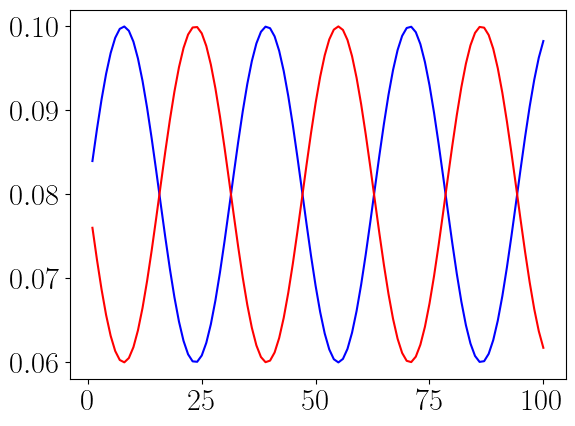

In [8]:
# Setup
nodes = np.arange(1,len(A)+1)

# Brusselator parameters
#b = 9
#c = 30
#D = [1, 7]
#wave1 = 1 + 0.2*np.sin(nodes/5)
#wave2 = 2 - wave1

# Mimura-Murray parameters
#a = 35
#b = 16
#c = 9
#d = 0.4
#D = [1, 0.0125]
#wave1 = np.maximum(5, 7 - np.abs(nodes - 50)/10)
#wave2 = wave1 + 5

# Fitzhugh-Nagumo parameters
a = 0.5
b = 0.04
c = 26
D = [0.2, 15]
wave1 = 0.08 + 0.02*np.sin(nodes/5)
wave2 = 0.16 - wave1

init = np.hstack(( wave1, wave2 ))
tspan = np.arange(0,100,0.01)
plt.plot(nodes,wave1,'b')
plt.plot(nodes,wave2,'r')

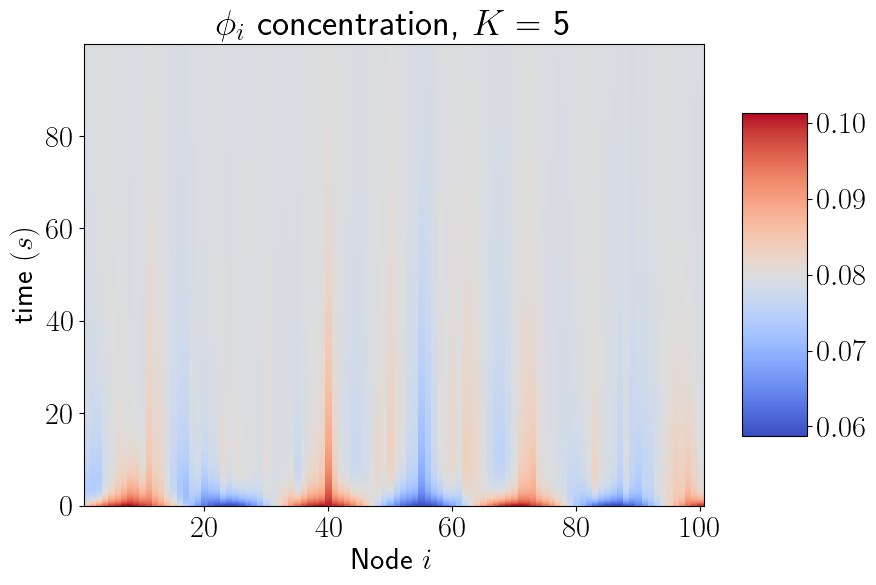

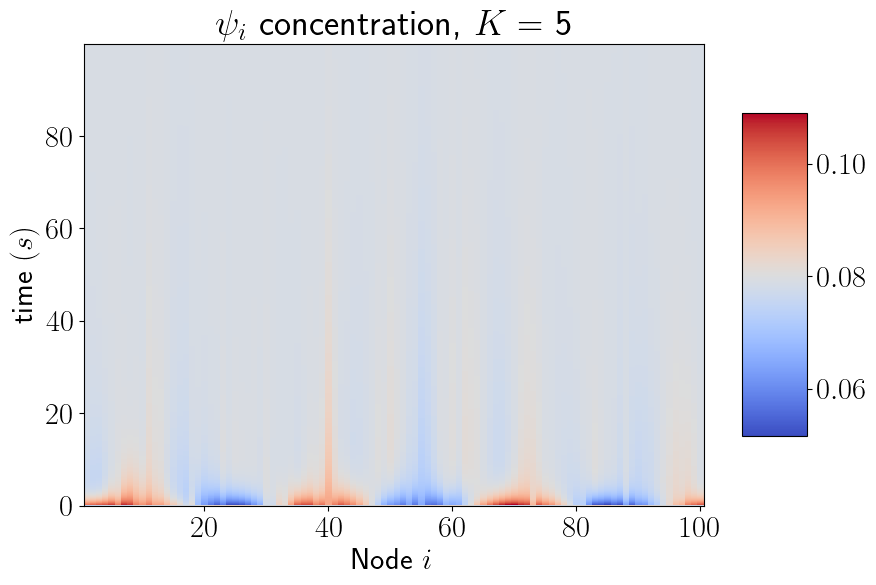

In [9]:
sol = simulate_rdm(adj, FitzhughNagumo, D, init, tspan, K)

p =  0.0


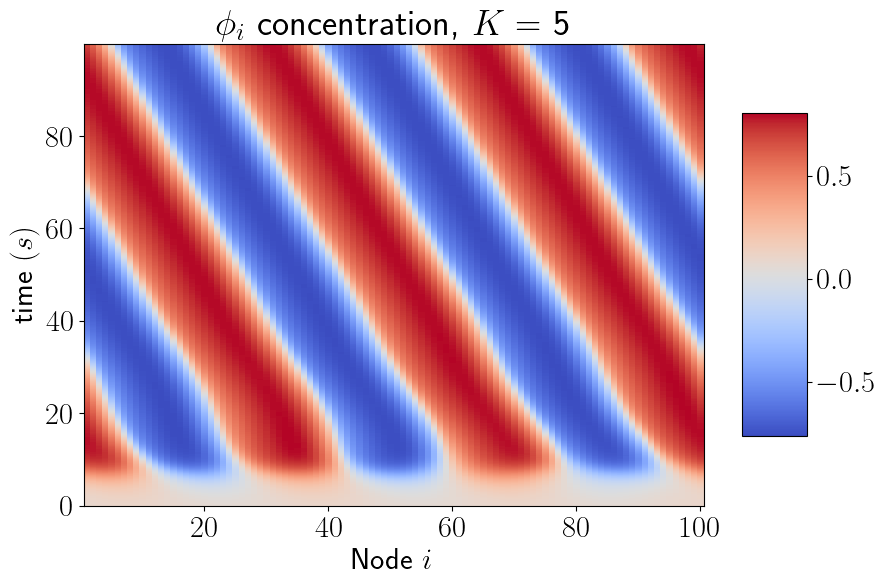

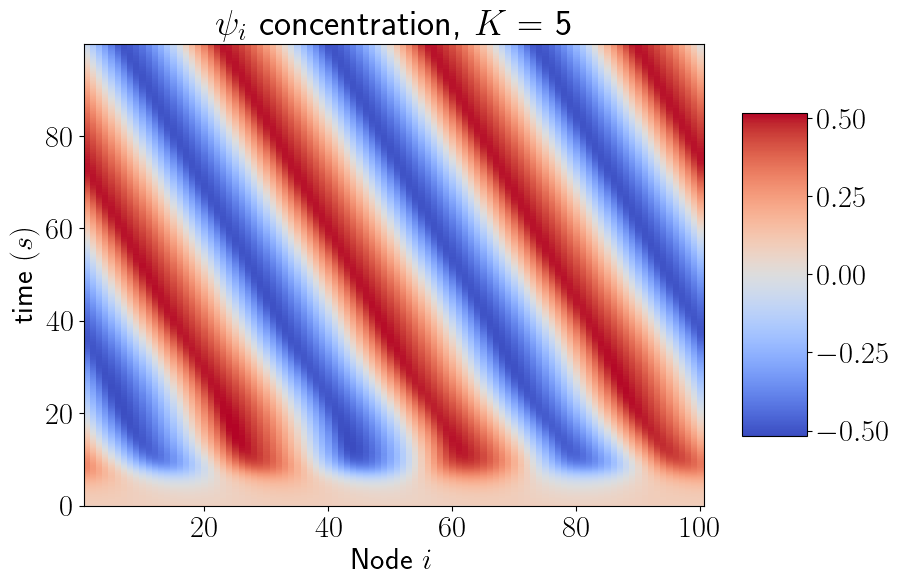

p =  0.1


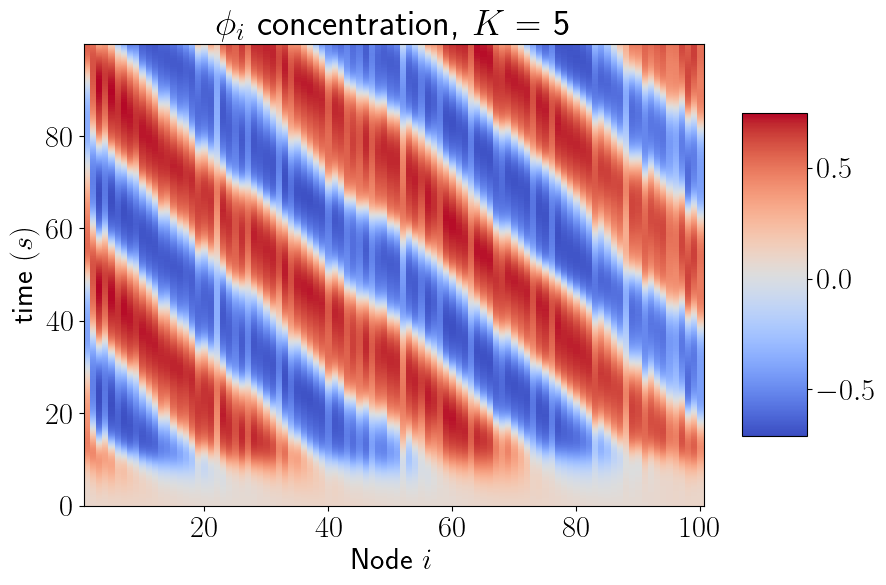

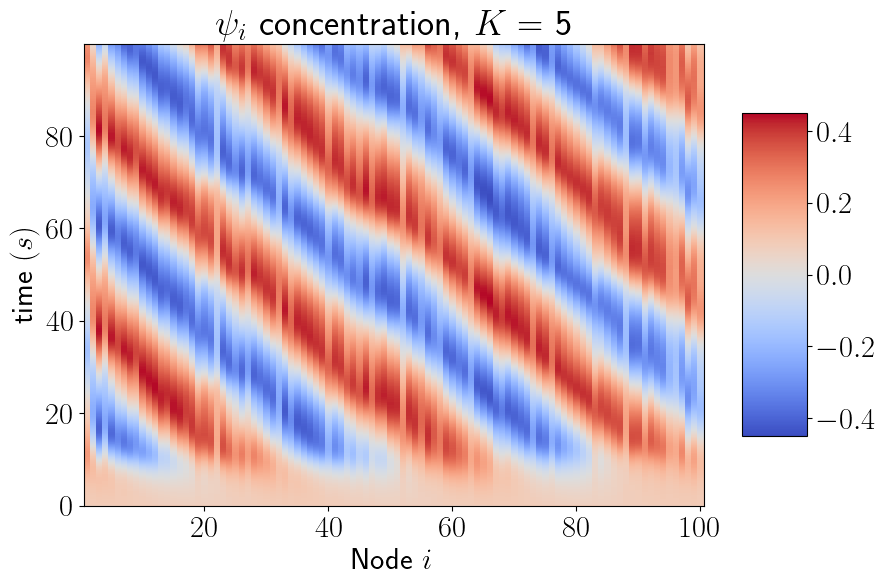

p =  0.2


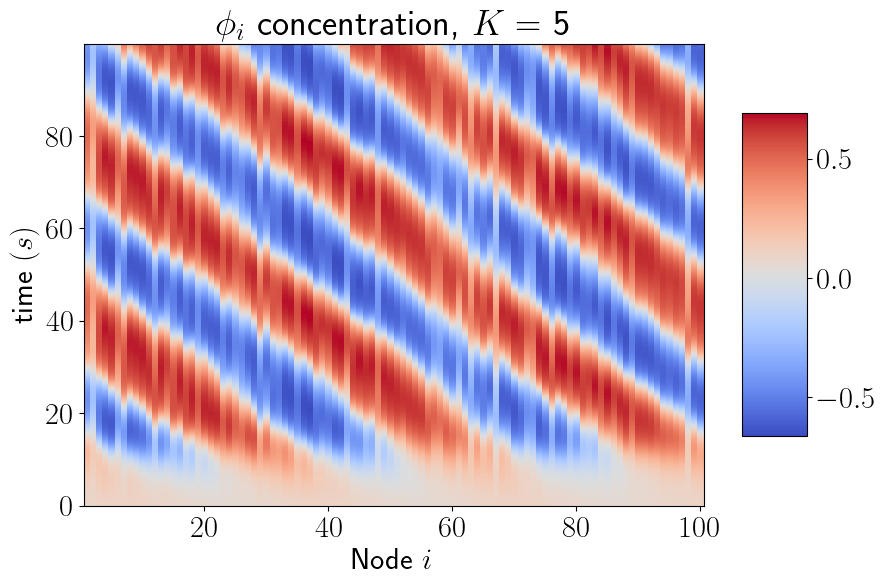

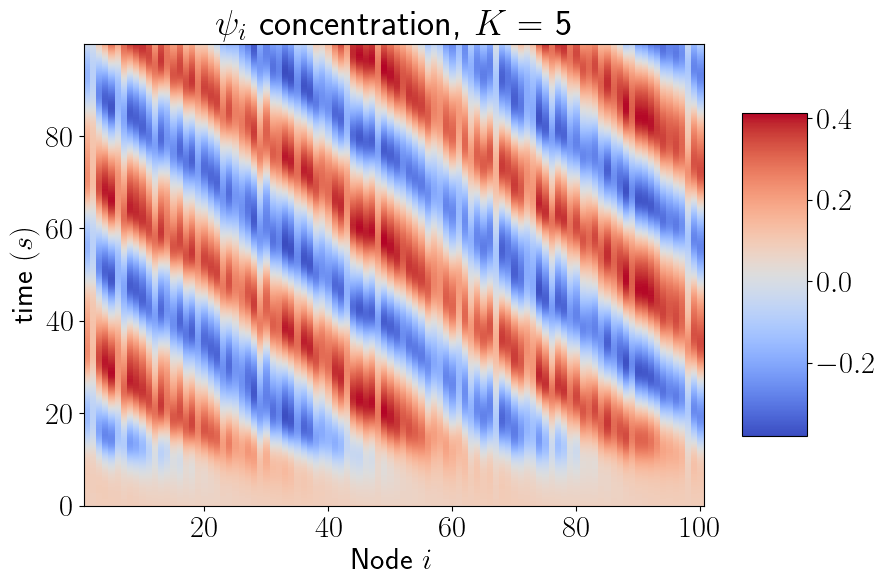

p =  0.3


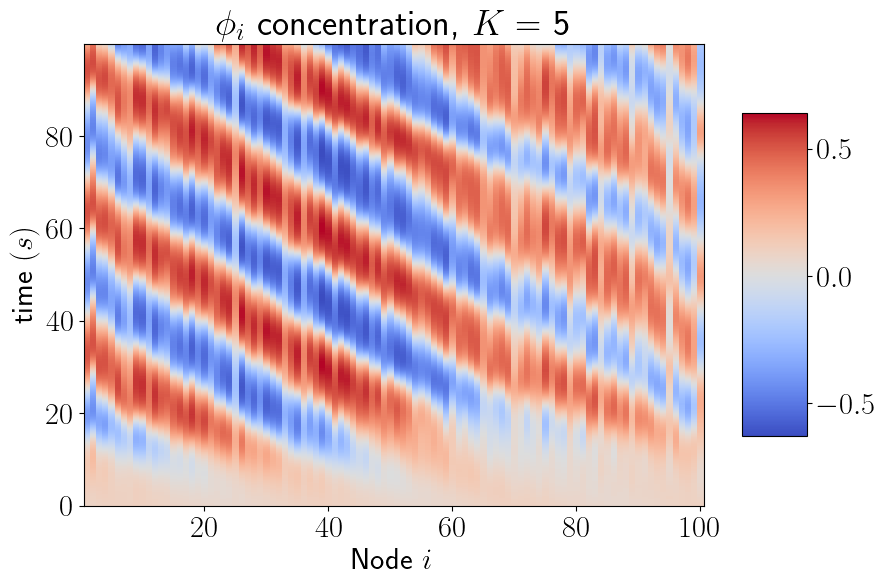

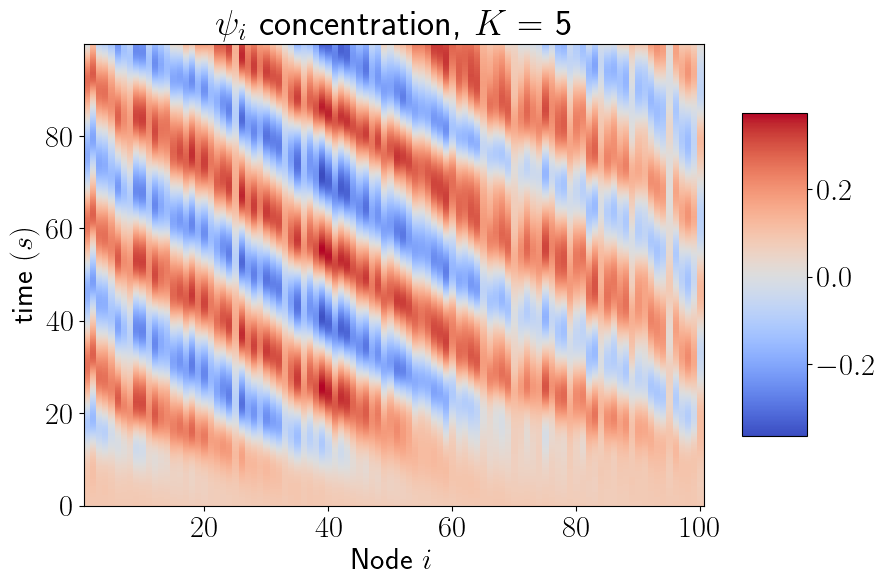

p =  0.4


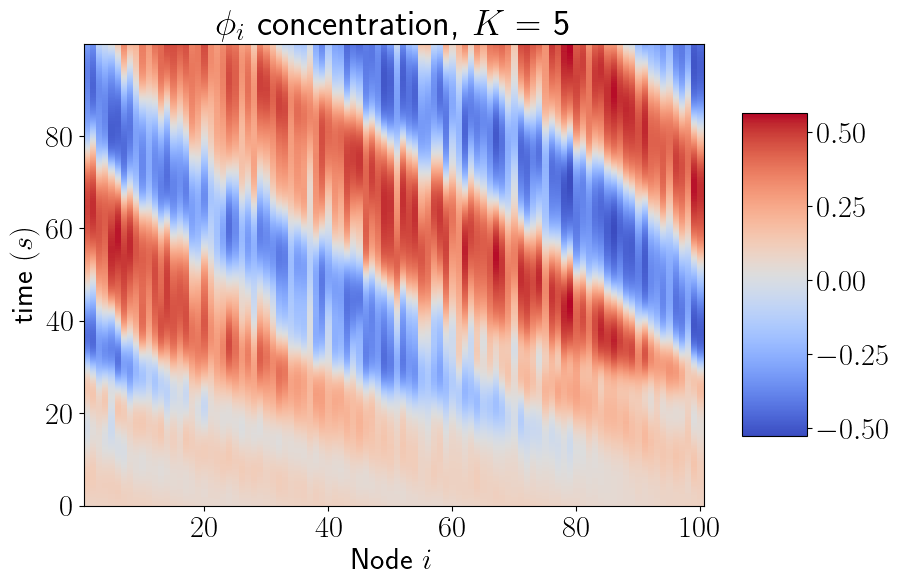

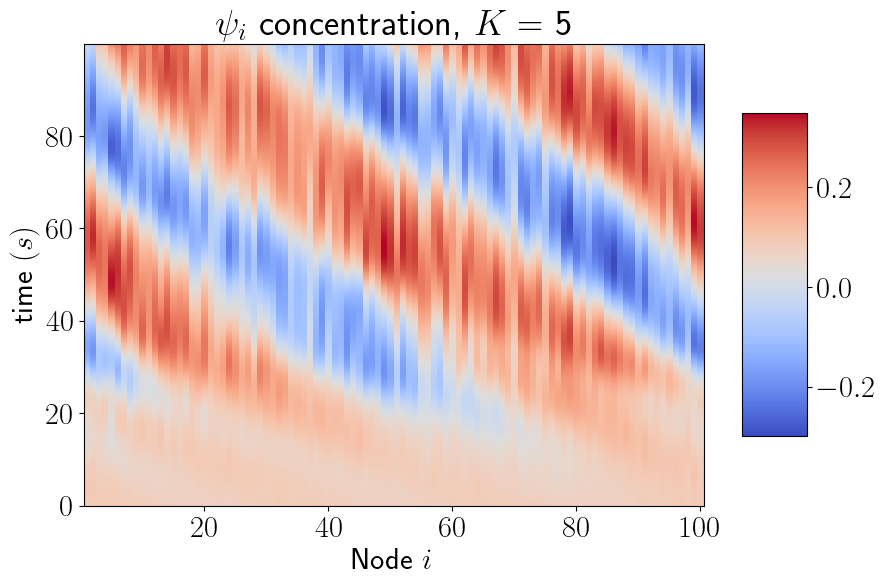

p =  0.5


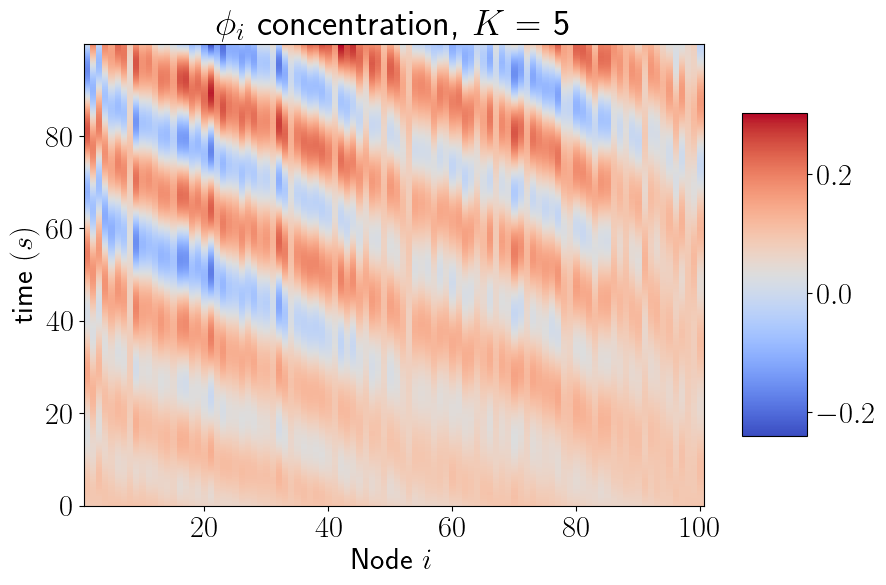

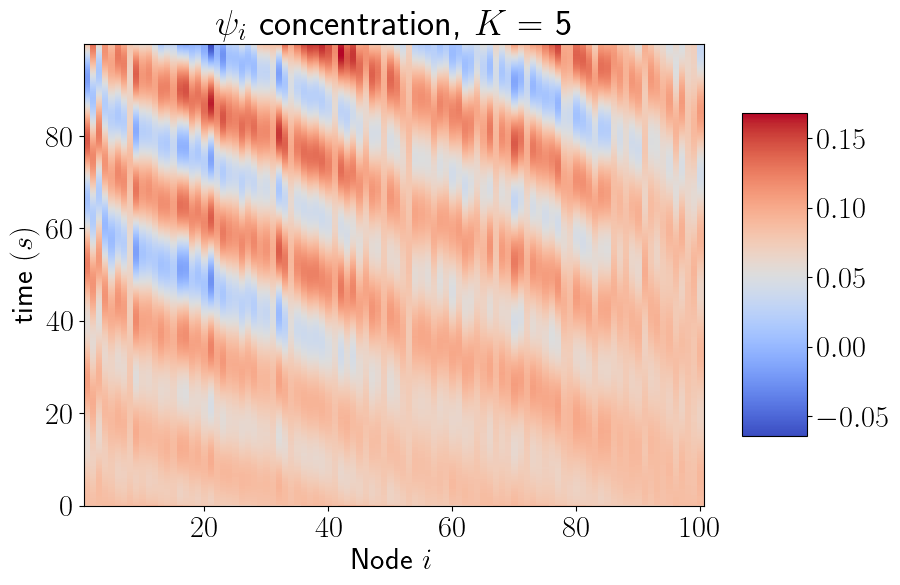

In [10]:
# fixing K = 10, varying p
for i in range(6):
    print('p = ', i/10)
    sol = simulate_rdm(Newman_Watts_generator(N, 5, i/10), FitzhughNagumo, D, init, tspan, 5)

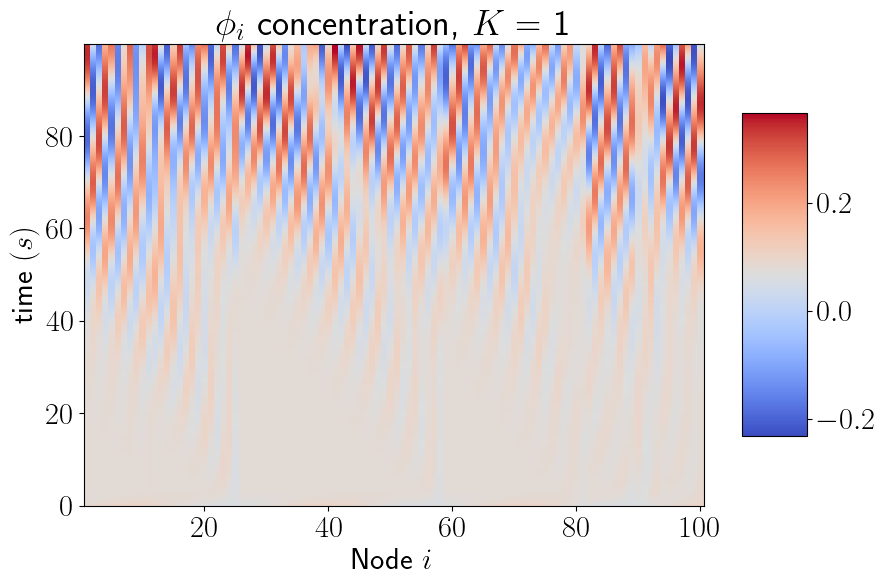

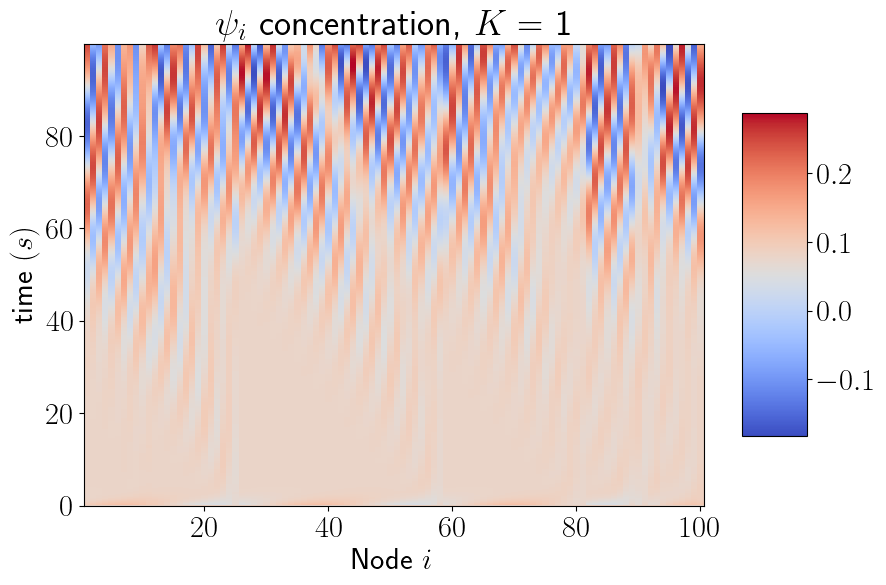

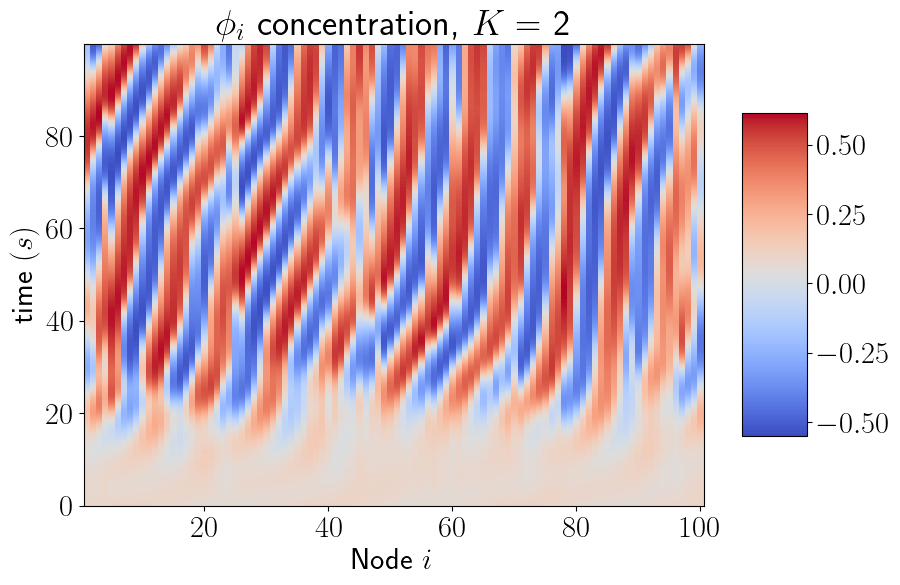

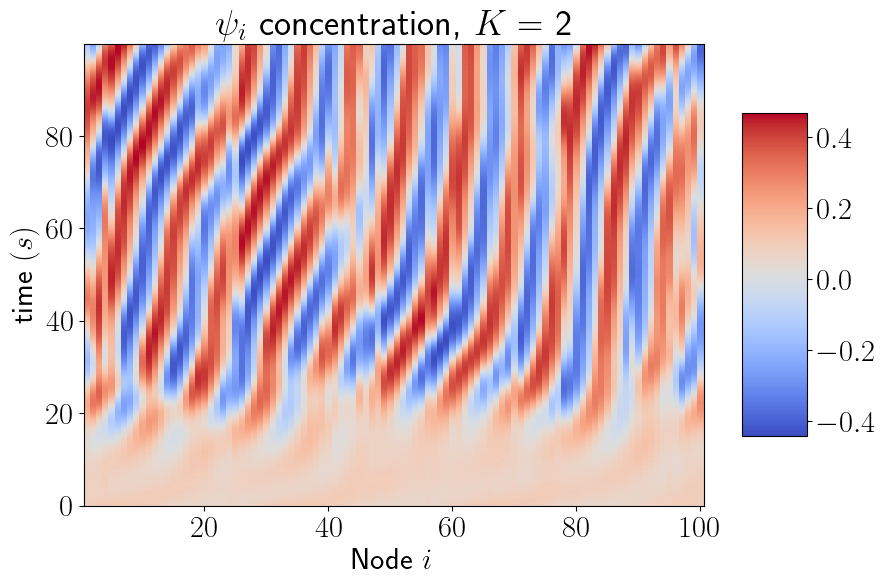

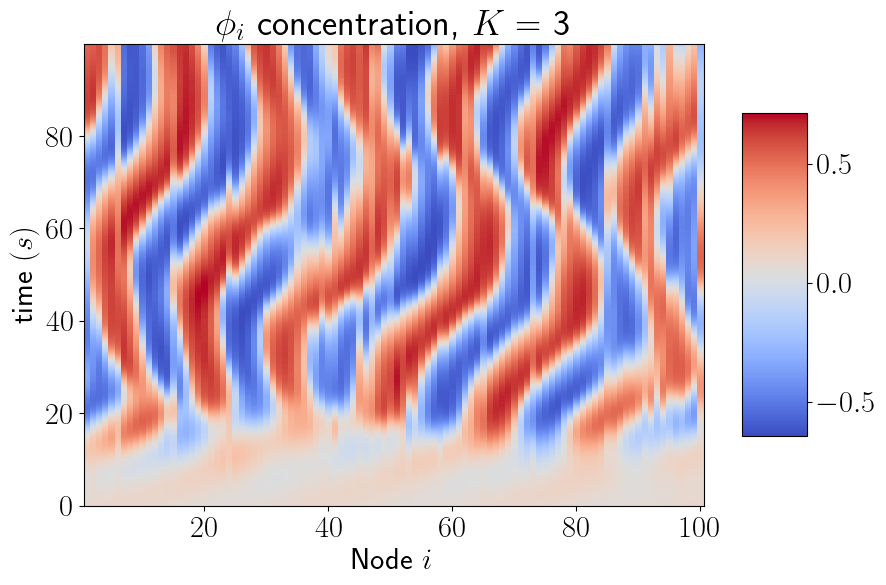

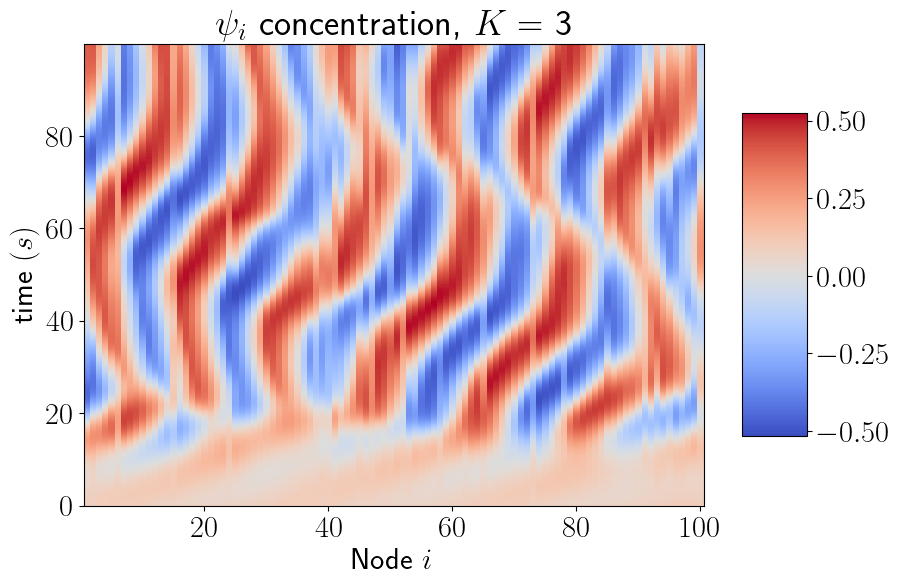

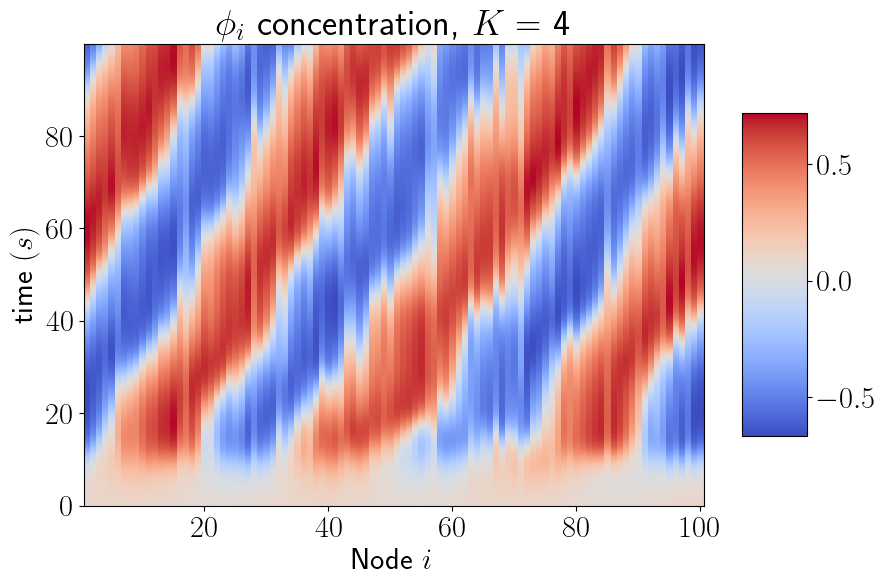

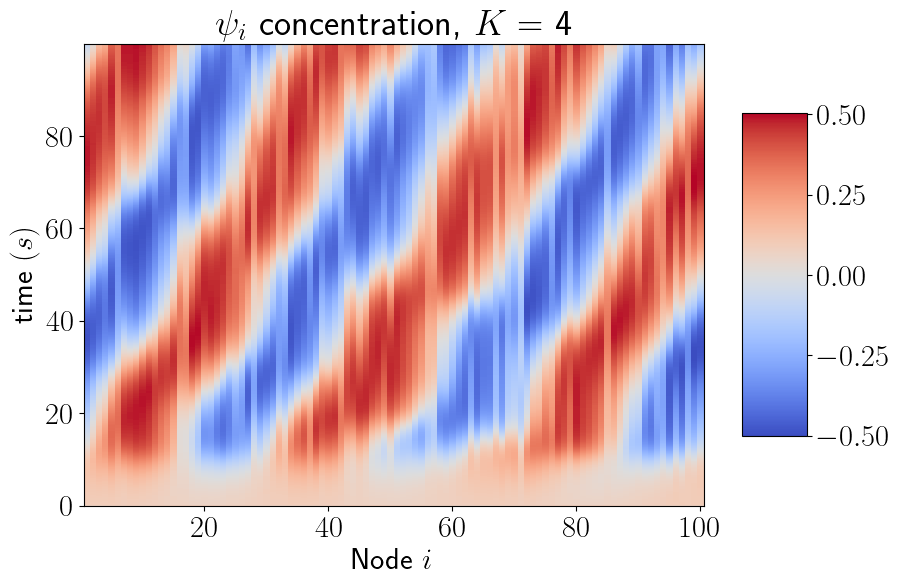

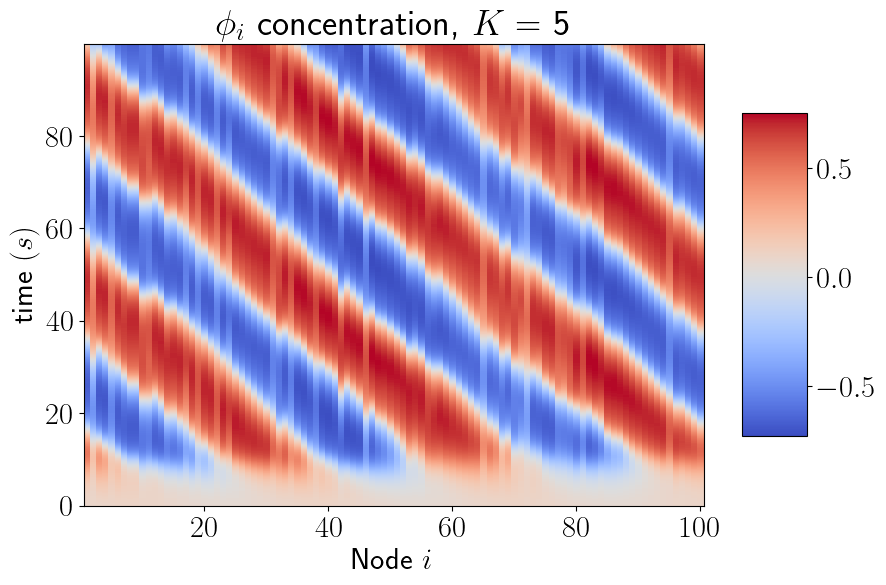

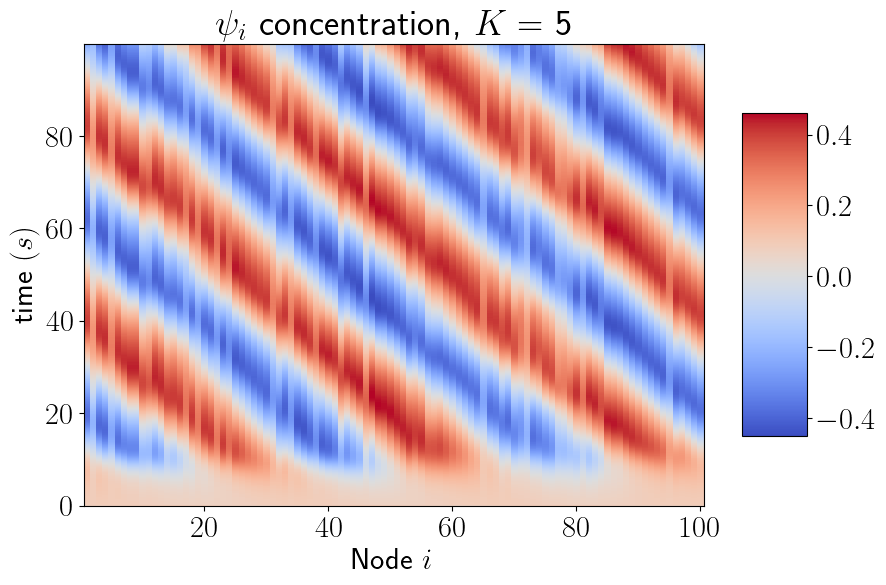

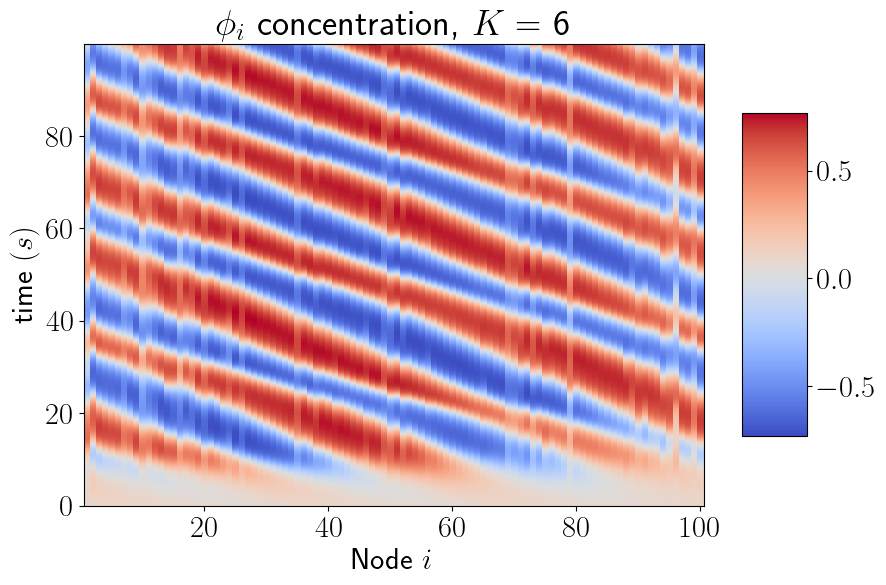

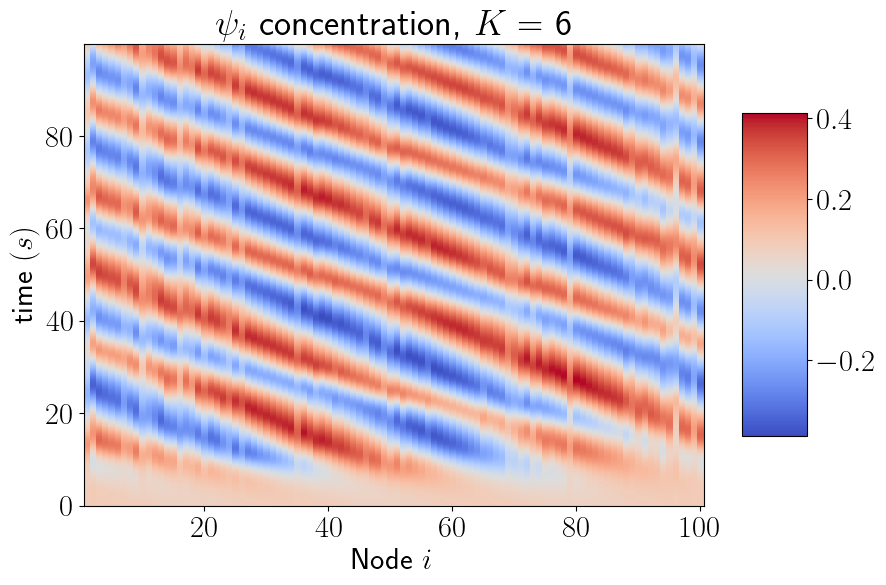

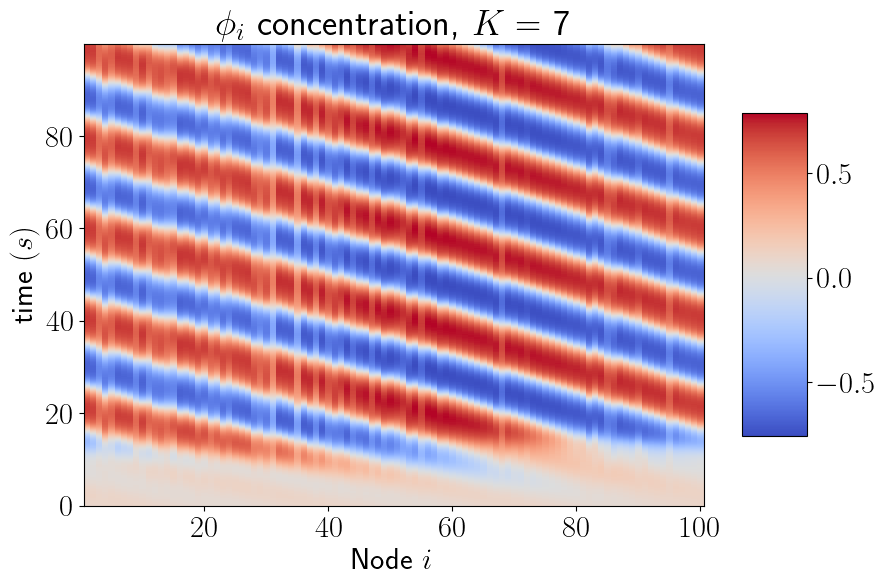

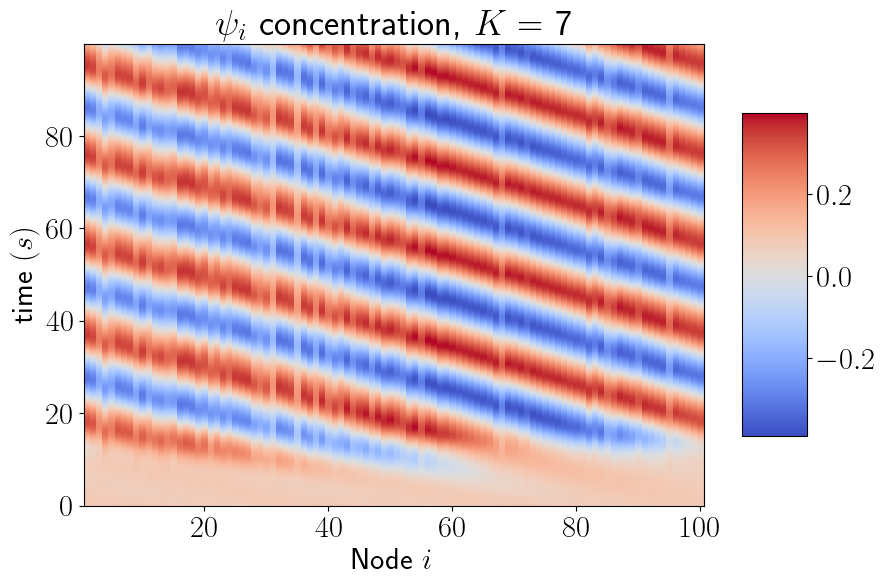

In [11]:
# fixing p = 0.1, varying K
for i in range(1,8):
    sol = simulate_rdm(Newman_Watts_generator(N, i, 0.1), FitzhughNagumo, D, init, tspan, i)